# Final Project

For your Final Project you will turn in 3 things:

1. Your code (in some timestamped way, either a PDF, GitHub link...etc)
2. A Technical Report with the following sections (Introduction, Analysis, Methods, Results, Reflection)
    - MAKE SURE your discussions are thourough (more thourough than for the Homeworks, as you're all doing different things and more discussion and background is needed. While visualizations are not required, they are strongly recommended where applicable)
3. (**For Groups**) A README file that also includes a description of how you diveded the labor between group members
3. (**For Individuals**) a README file.

Remember, your technical report should be a *standalone* document, so you should copy any tables, images, results into the report, not leave them in your notebook/code file.

You will be judged on the following rubric criteria:

- Quality of technical report 
    - Introduction provides reader with all the necessary background and information about the data, and importance of the problem being solved is apparent
    - Analysis demonstrates a deep understanding of the data and provides the reader with the context necessary to understand both the problem and the modelling choices.
    - Methods is complete, appropriate for the task, and would allow someone to roughly recreate the model(s) used. Reasoning behind choices made when building the model are provided. 
    - Results provides a nuanced and detailed discussion of the model performance (e.g. beyond simple overall metrics), and discusses the implication of these results (e.g. how they affect whether the model could be used, whether performance differs for different groups, etc. )
    - Reflection demonstrates that student(s) understand the problem at hand, had an organized way of approaching the problem, recognize limitations of the curent analysis, and have thought about improvements taht can be made to the model(s) in the future.  
- Code is Organized and appropriate for task (e.g. the architecture chosen is appropriate for the problem, the loss function matches the desired output, metrics are appropriate for the task, no data leakage, code runs as intended...etc.)
- Quality of Problem (the problem being solved and the questions being answered are sufficiently complex)

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image

from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as kb
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow import keras
from tensorflow.keras import layers, backend
from tensorflow.keras.models import Sequential

import os
import random
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19



In [3]:
!mkdir ~/.kaggle
import json

token = {"username":"jordanbruce3135","key":"b34c5ebb552d3f486f0dcfa132830908"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

brain-tumor-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip brain-tumor-mri-dataset.zip

Archive:  brain-tumor-mri-dataset.zip
replace Testing/glioma/Te-glTr_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
train_path = "/content/Training"
test_path = "/content/Testing"


In [7]:
batch_size = 32
img_height = 224
img_width = 224

In [8]:
train2_ds = tf.keras.preprocessing.image_dataset_from_directory(train_path,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

Found 5712 files belonging to 4 classes.


In [9]:
test2_ds = tf.keras.preprocessing.image_dataset_from_directory(test_path,
                                                               image_size=(img_height, img_width),
                                                               batch_size=batch_size)

Found 1311 files belonging to 4 classes.


In [10]:
class_names = train2_ds.class_names ############
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


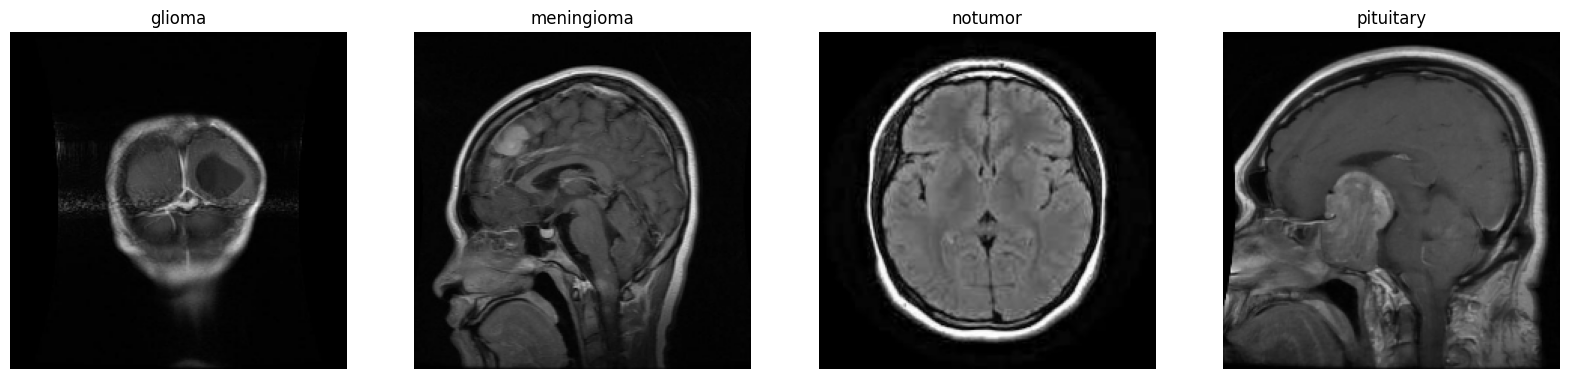

In [11]:
# Create a figure with subplots for each class
fig, axs = plt.subplots(1, len(class_names), figsize=(20, 5))

# Loop through each class and display the first image in that class
for i, class_name in enumerate(class_names):
    for images, labels in train2_ds: ##########
        first_image = images[labels == i][0]
        axs[i].imshow(first_image.numpy().astype("uint8"))
        axs[i].set_title(class_name)
        axs[i].axis("off")
        break
plt.show()

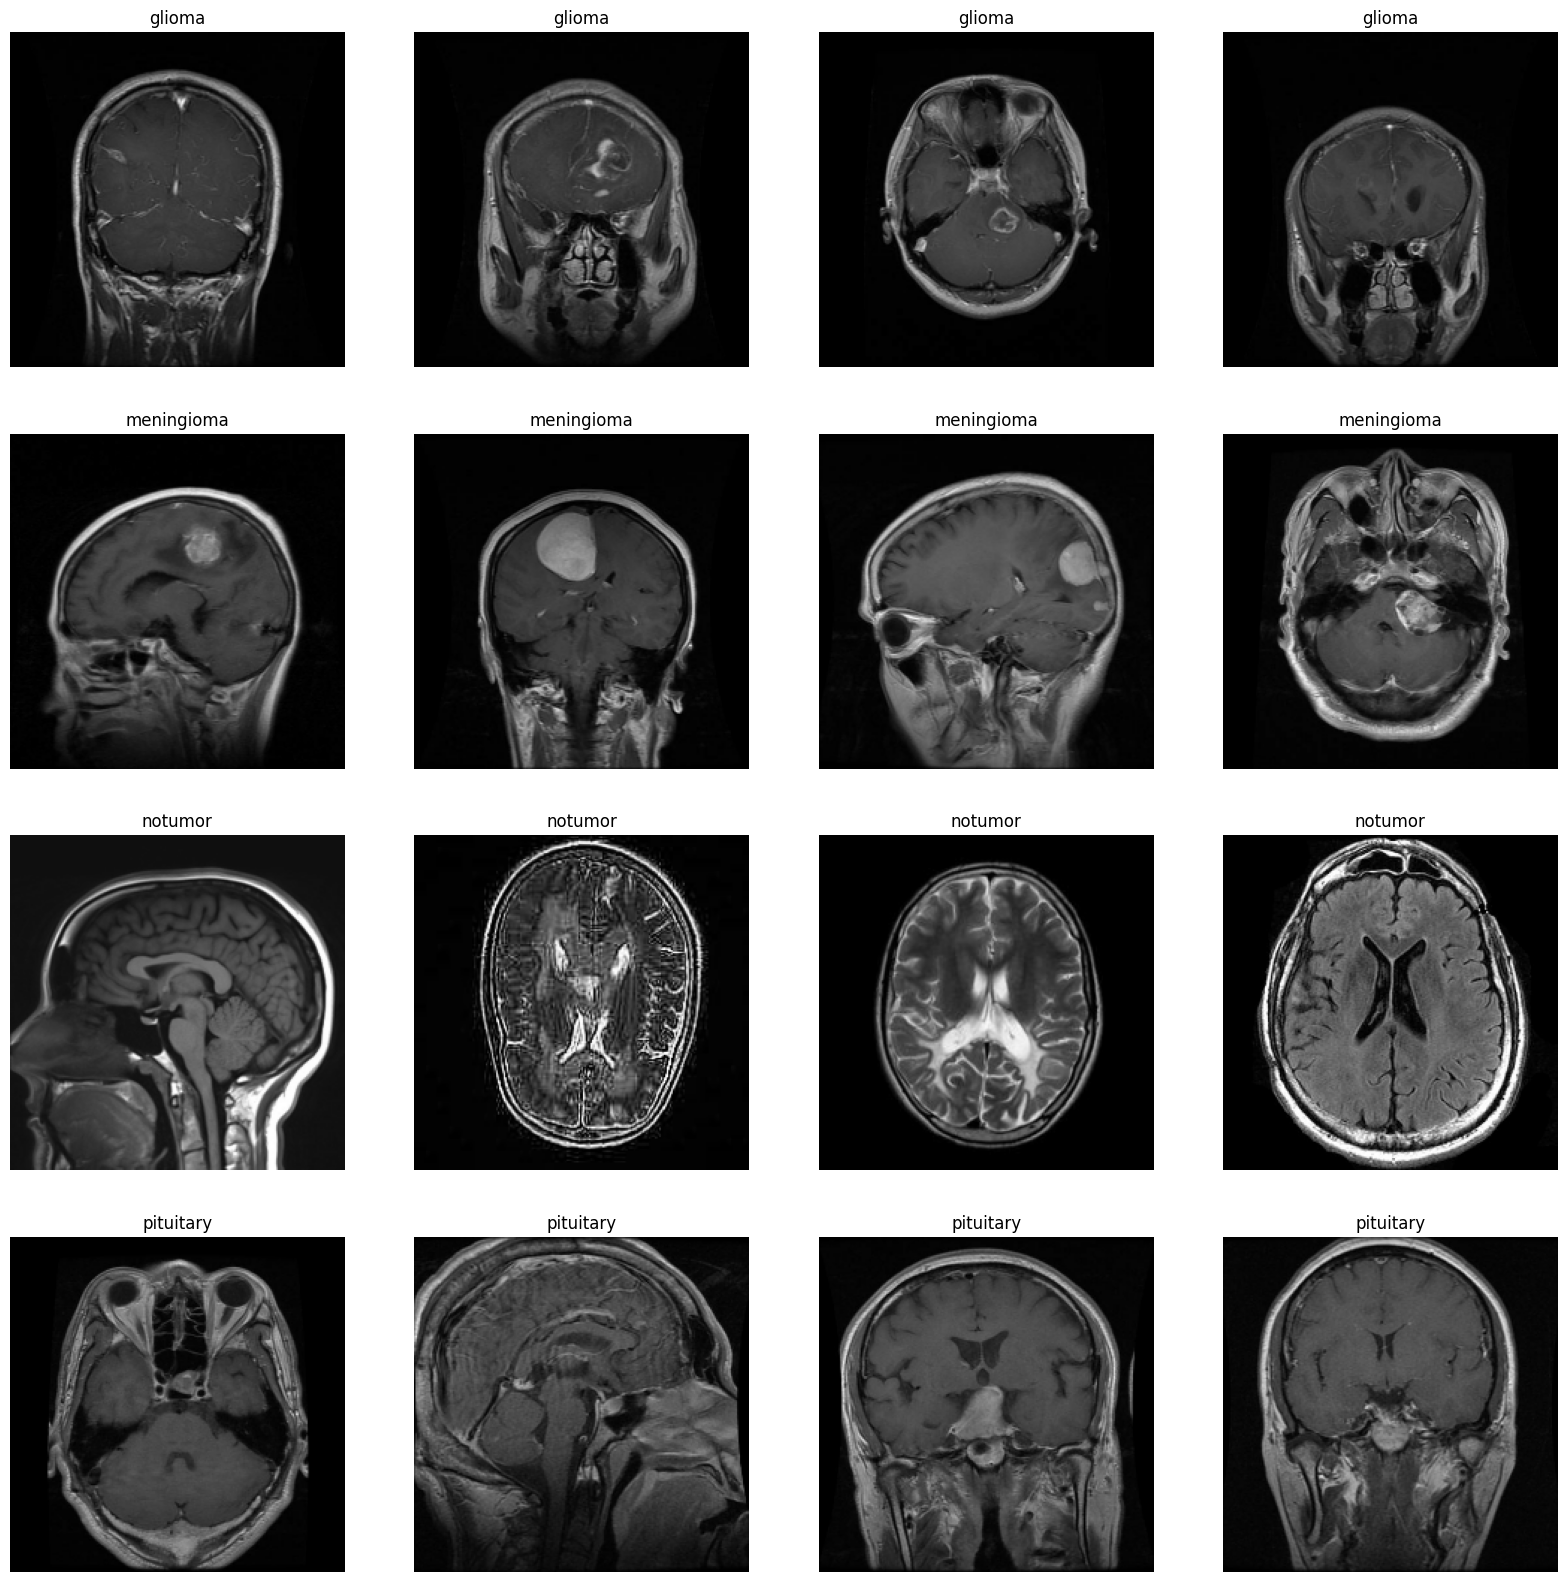

In [12]:
# Create a figure with subplots for each class
fig, axs = plt.subplots(len(class_names), 4, figsize=(20, 20))

# Loop through each class and display the first 4 images in that class
for i, class_name in enumerate(class_names):
    for images, labels in train2_ds: ############
        class_images = images[labels == i]
        for j in range(min(4, len(class_images))):
            axs[i, j].imshow(class_images[j].numpy().astype("uint8"))
            axs[i, j].set_title(class_name)
            axs[i, j].axis("off")
        break
plt.show()

<ipython-input-13-8e30896d0d17>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(class_names)


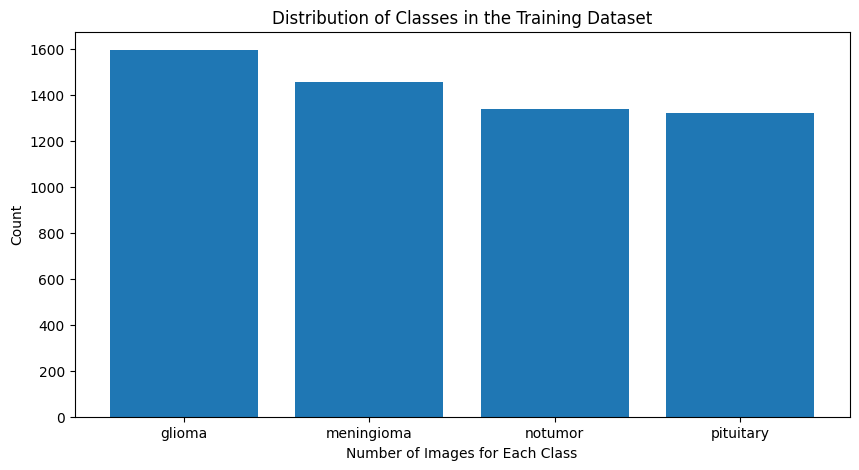

In [13]:
class_counts = {}
for image_batch, label_batch in train2_ds: ############
    for label in label_batch:
        class_name = class_names[label.numpy()]
        if class_name not in class_counts:
            class_counts[class_name] = 1
        else:
            class_counts[class_name] += 1

# Sort the classes by count in descending order
class_counts_sorted = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

# Create a bar chart to show the distribution of classes
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar([x[0] for x in class_counts_sorted], [x[1] for x in class_counts_sorted])
ax.set_xlabel('Number of Images for Each Class')
ax.set_xticklabels(class_names)
ax.set_ylabel('Count')
ax.set_title('Distribution of Classes in the Training Dataset')
plt.show()


<ipython-input-14-ca3579d659a4>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(class_names)


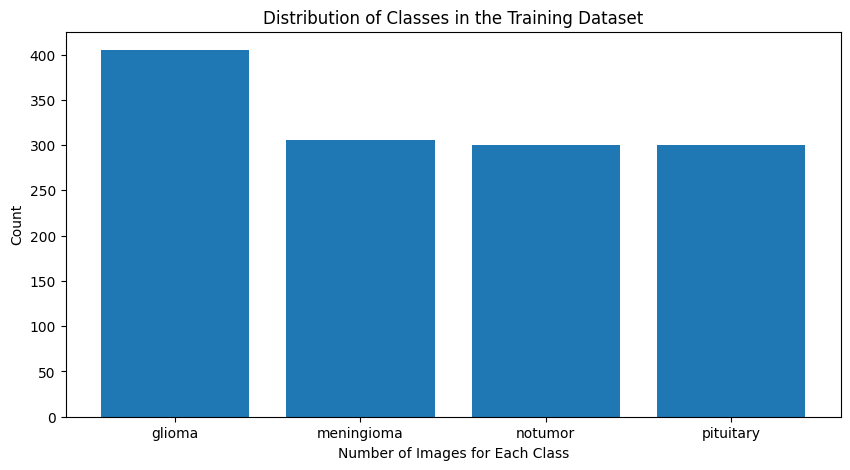

In [14]:
class_counts = {}
for image_batch, label_batch in test2_ds: ############
    for label in label_batch:
        class_name = class_names[label.numpy()]
        if class_name not in class_counts:
            class_counts[class_name] = 1
        else:
            class_counts[class_name] += 1

# Sort the classes by count in descending order
class_counts_sorted = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

# Create a bar chart to show the distribution of classes
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar([x[0] for x in class_counts_sorted], [x[1] for x in class_counts_sorted])
ax.set_xlabel('Number of Images for Each Class')
ax.set_xticklabels(class_names)
ax.set_ylabel('Count')
ax.set_title('Distribution of Classes in the Training Dataset')
plt.show()

In [15]:
model = kb.Sequential([
    kb.layers.Rescaling(1./255, input_shape =(img_height, img_width, 3)),
    kb.layers.RandomFlip(),
    kb.layers.RandomZoom(0.2),
    kb.layers.RandomRotation(0.2),
    kb.layers.Conv2D(32, (3, 3), activation='relu'),
    kb.layers.Conv2D(32, (3, 3), activation='relu'),
    kb.layers.Dropout(0.2),
    kb.layers.Dense(64,activation='relu'),
    kb.layers.MaxPooling2D((2, 2)),
    kb.layers.Conv2D(64, (3, 3), activation='relu'),
    kb.layers.Conv2D(64, (3, 3), activation='relu'),
    kb.layers.Dropout(0.2),
    kb.layers.Dense(64,activation='relu'),
    kb.layers.MaxPooling2D((3, 3)),
    kb.layers.Conv2D(128, (3, 3), activation='relu'),
    kb.layers.Conv2D(128, (3, 3), activation='relu'),
    kb.layers.Dropout(0.2),
    kb.layers.Dense(128,activation='relu'),
    kb.layers.MaxPooling2D((3, 3)),
    kb.layers.Flatten(),
    kb.layers.Dense(100, activation='relu'),
    kb.layers.Flatten(),
    kb.layers.Dense(128,activation='relu'),
    kb.layers.Dense(64,activation='relu'),
    kb.layers.Dense(32,activation='relu'),
    kb.layers.Dense(4, activation='softmax'),
])



In [16]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(lr=0.001),
    metrics = [
        "accuracy","mse", "mae"
    ])

In [17]:
history = model.fit(x=train2_ds,
                    epochs= 10,
                    validation_data=test2_ds)

Epoch 1/10
179/179 [==============================] - 60s 268ms/step - loss: 1.0858 - accuracy: 0.5158 - mse: 2.9703 - mae: 1.4238 - val_loss: 1.2642 - val_accuracy: 0.4241 - val_mse: 2.8469 - val_mae: 1.4022
Epoch 2/10
179/179 [==============================] - 44s 243ms/step - loss: 0.8911 - accuracy: 0.6329 - mse: 2.9965 - mae: 1.4238 - val_loss: 1.2479 - val_accuracy: 0.4233 - val_mse: 2.8618 - val_mae: 1.4022
Epoch 3/10
179/179 [==============================] - 43s 238ms/step - loss: 0.8271 - accuracy: 0.6626 - mse: 3.0040 - mae: 1.4238 - val_loss: 0.9769 - val_accuracy: 0.6072 - val_mse: 2.8745 - val_mae: 1.4022
Epoch 4/10
179/179 [==============================] - 43s 240ms/step - loss: 0.7605 - accuracy: 0.6889 - mse: 3.0126 - mae: 1.4238 - val_loss: 0.9400 - val_accuracy: 0.6178 - val_mse: 2.8840 - val_mae: 1.4022
Epoch 5/10
179/179 [==============================] - 43s 241ms/step - loss: 0.6943 - accuracy: 0.7199 - mse: 3.0212 - mae: 1.4238 - val_loss: 1.0247 - val_accuracy

In [44]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Make predictions on the test set
test_images = []
test_labels = []

for images, labels in test2_ds:
    test_images.extend(images)
    test_labels.extend(labels)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Create the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
print(cm)

41/41 [==============================] - 2s 58ms/step
[[236  14   4  46]
 [121  70  53  62]
 [ 23  20 332  30]
 [ 16  10  19 255]]


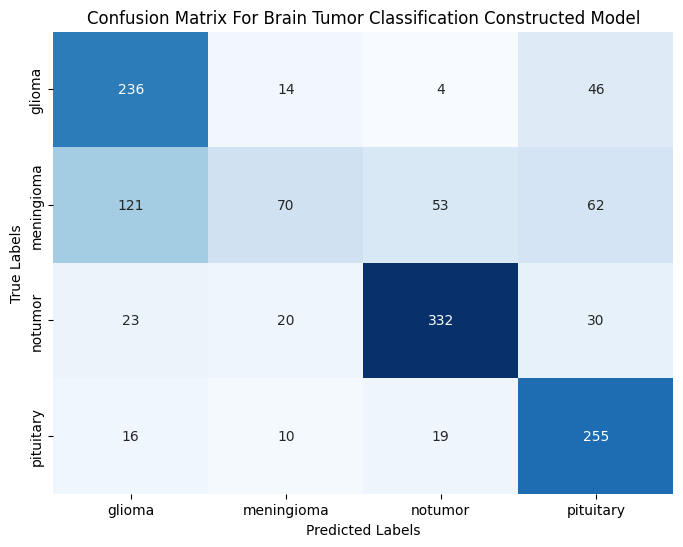

In [45]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix For Brain Tumor Classification Constructed Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

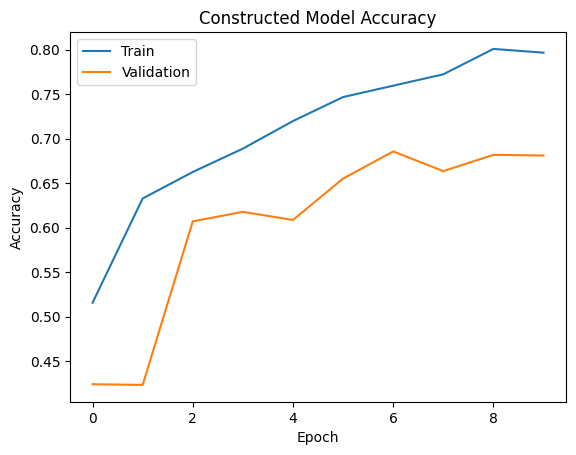

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Constructed Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

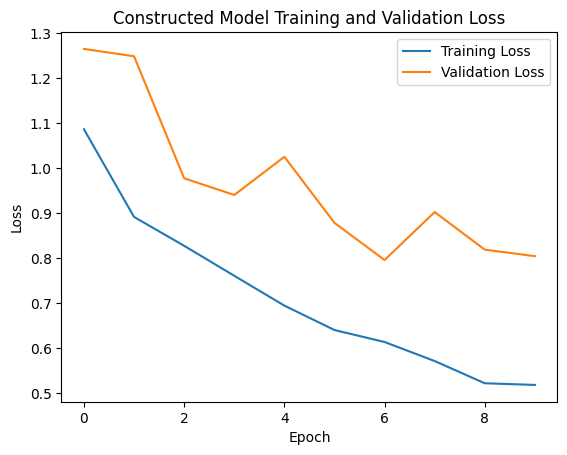

In [36]:
# Get the training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a figure with a single subplot
fig, ax = plt.subplots()

# Plot the training and validation loss
ax.plot(train_loss, label='Training Loss')
ax.plot(val_loss, label='Validation Loss')

# Add title and axis labels
ax.set_title('Constructed Model Training and Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Add legend
ax.legend()

# Display the plot
plt.show()

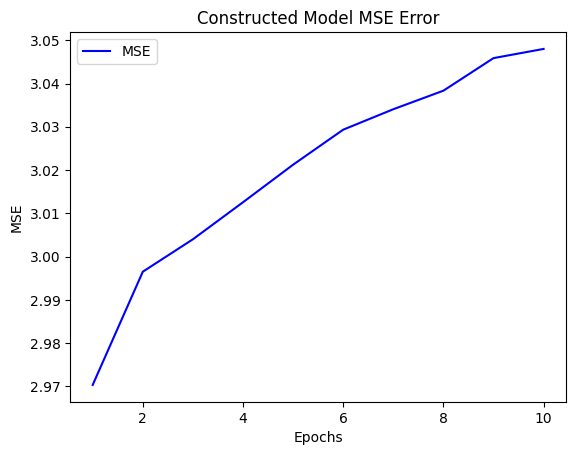

In [37]:
# Extract the MSE values from the history
mse = history.history['mse']

# Plot the MSE error
epochs = range(1, len(mse) + 1)
plt.plot(epochs, mse, 'b', label='MSE')
plt.title('Constructed Model MSE Error')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [23]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import regularizers

vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg.layers:
    layer.trainable = False

model_vgg = kb.Sequential([
    vgg,
    kb.layers.Flatten(),
    kb.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    kb.layers.BatchNormalization(),
    kb.layers.Dropout(0.5),
    kb.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    kb.layers.BatchNormalization(),
    kb.layers.Dropout(0.5),
    kb.layers.Dense(4, activation='softmax')
])

In [24]:
vgg_conv = kb.applications.vgg16.VGG16(
    weights = "imagenet",
    include_top = False,
    input_shape = (224,224,3)
)

vgg_conv.trainable = False
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [25]:
model_vgg.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(lr=0.001),
    metrics = ["accuracy", "mse", "mae"])

In [26]:
history_vgg = model_vgg.fit(x=train2_ds,
                    epochs= 10,
                    validation_data=test2_ds)

Epoch 1/10
179/179 [==============================] - 44s 206ms/step - loss: 3.7049 - accuracy: 0.8127 - mse: 3.0683 - mae: 1.4238 - val_loss: 2.3026 - val_accuracy: 0.8886 - val_mse: 2.9741 - val_mae: 1.4022
Epoch 2/10
179/179 [==============================] - 29s 162ms/step - loss: 1.9474 - accuracy: 0.8846 - mse: 3.0838 - mae: 1.4238 - val_loss: 1.6326 - val_accuracy: 0.9130 - val_mse: 2.9790 - val_mae: 1.4022
Epoch 3/10
179/179 [==============================] - 29s 163ms/step - loss: 1.4581 - accuracy: 0.9042 - mse: 3.0873 - mae: 1.4238 - val_loss: 1.2685 - val_accuracy: 0.9169 - val_mse: 2.9793 - val_mae: 1.4022
Epoch 4/10
179/179 [==============================] - 30s 164ms/step - loss: 1.2736 - accuracy: 0.8967 - mse: 3.0871 - mae: 1.4238 - val_loss: 1.1603 - val_accuracy: 0.9367 - val_mse: 2.9759 - val_mae: 1.4022
Epoch 5/10
179/179 [==============================] - 29s 163ms/step - loss: 1.1840 - accuracy: 0.8974 - mse: 3.0856 - mae: 1.4238 - val_loss: 1.0719 - val_accuracy

In [27]:
# Make predictions on the test set
test_images = []
test_labels = []

for images, labels in test2_ds:
    test_images.extend(images)
    test_labels.extend(labels)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

predictions = model_vgg.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Create the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
print(cm)

41/41 [==============================] - 5s 126ms/step
[[232  46   5  17]
 [  6 186  41  73]
 [  1   0 403   1]
 [  0   0   0 300]]


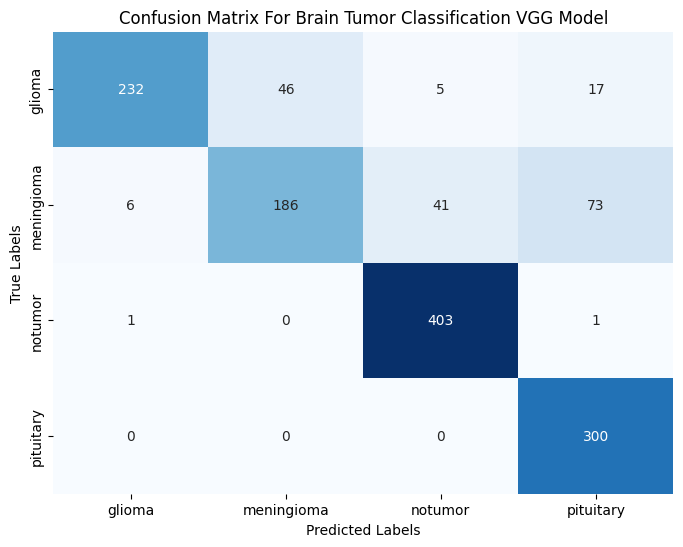

In [38]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix For Brain Tumor Classification VGG Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

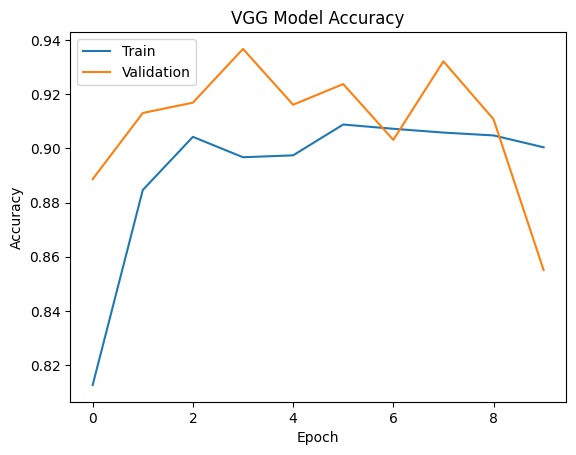

In [40]:
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.title('VGG Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

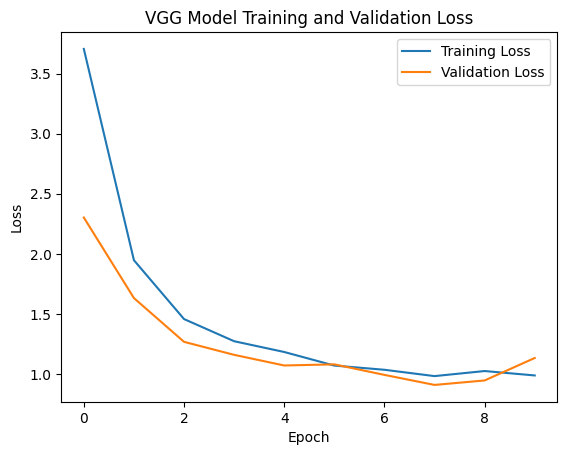

In [41]:
# Get the training and validation loss from the history object
train_loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']

# Create a figure with a single subplot
fig, ax = plt.subplots()

# Plot the training and validation loss
ax.plot(train_loss, label='Training Loss')
ax.plot(val_loss, label='Validation Loss')

# Add title and axis labels
ax.set_title('VGG Model Training and Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Add legend
ax.legend()

# Display the plot
plt.show()

In [31]:
# Extract metrics from history for model 1
accuracy_model = history.history['accuracy']
loss_model = history.history['loss']
mse_model = history.history['mse']
mae_model = history.history['mae']

# Extract metrics from history for model 2
accuracy_model_vgg = history_vgg.history['accuracy']
loss_model_vgg = history_vgg.history['loss']
mse_model_vgg = history_vgg.history['mse']
mae_model_vgg = history_vgg.history['mae']

epochs = range(1, len(accuracy_model) + 1)

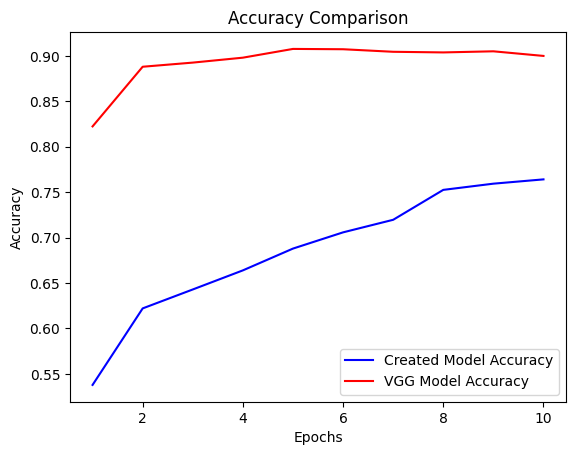

In [70]:
plt.plot(epochs, accuracy_model, 'b', label='Created Model Accuracy')
plt.plot(epochs, accuracy_model_vgg, 'r', label='VGG Model Accuracy')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

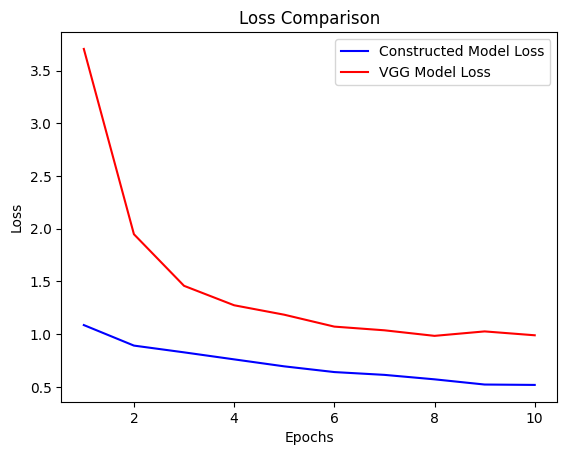

In [42]:
plt.plot(epochs, loss_model, 'b', label='Constructed Model Loss')
plt.plot(epochs, loss_model_vgg, 'r', label='VGG Model Loss')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

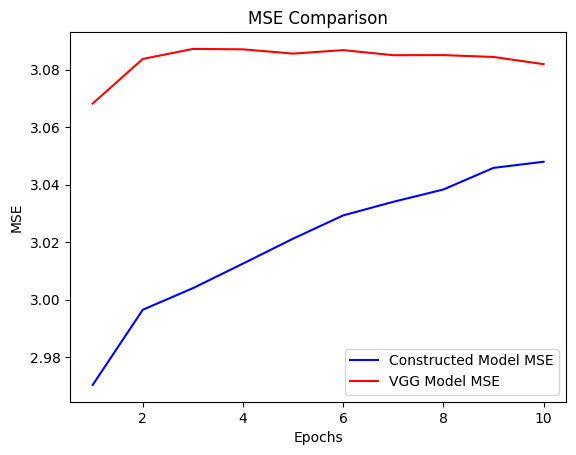

In [43]:
plt.plot(epochs, mse_model, 'b', label='Constructed Model MSE')
plt.plot(epochs, mse_model_vgg, 'r', label='VGG Model MSE')
plt.title('MSE Comparison')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

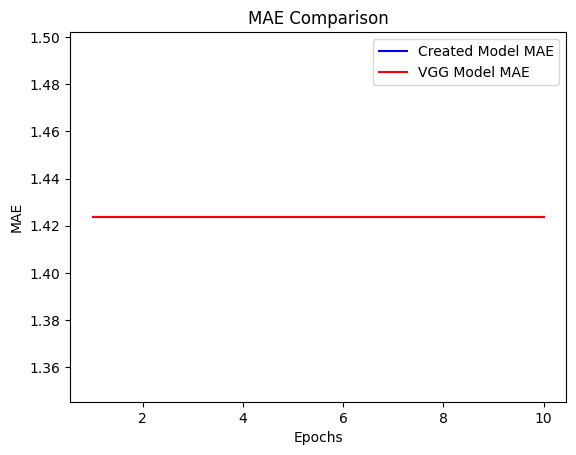

In [34]:
plt.plot(epochs, mae_model, 'b', label='Created Model MAE')
plt.plot(epochs, mae_model_vgg, 'r', label='VGG Model MAE')
plt.title('MAE Comparison')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Technical Report Guidelines
## Introduction
An introduction should introduce the problem you're working on, give some background and relevant detail for the reader, and explain why it is important. 

## Analysis 
Any exploratory analysis of your data, and general summarization of the data (e.g. summary statistics, correlation heatmaps, graphs, information about the data...). This can also include any cleaning and joining you did. 

## Methods
Explain the structure of your model and your approach to building it. This can also include changes you made to your model in the process of building it. Someone should be able to read your methods section and *generally* be able to tell exactly what architechture you used. 

## Results
Detailed discussion of how your model performed, and your discussion of how your model performed.

## Reflection
Reflections on what you learned/discovered in the process of doing the assignment. Things you would do differently in the future, ways you'll approach similar problems in the future, etc.
